In [22]:
import requests
import time

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import requests_cache
import numpy as np

requests_cache.install_cache()

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

%matplotlib inline

In [2]:
# TODO: Add normalization of the song names (remove (feat. ...))
# TODO: Alternatively, load all songs from the artist and find out the mib to definitely find the song

# Artist & Song Dataframe

Load lyrics dataframe 

In [3]:
lyrics_df = pd.read_csv("../data/lyrics-data.csv")
artists_df = pd.read_csv('../data/artists-data.csv')

Show general information for the dataframes

In [4]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379931 entries, 0 to 379930
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ALink     379930 non-null  object
 1   SName     379928 non-null  object
 2   SLink     379930 non-null  object
 3   Lyric     379854 non-null  object
 4   language  365296 non-null  object
dtypes: object(5)
memory usage: 14.5+ MB


In [5]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      4167 non-null   object 
 1   Genres      4163 non-null   object 
 2   Songs       4167 non-null   float64
 3   Popularity  4166 non-null   float64
 4   Link        4167 non-null   object 
dtypes: float64(2), object(3)
memory usage: 162.9+ KB


Create dataframe with song name and artist name (only English songs)

In [6]:
artists_songs_dataframe = pd.merge(artists_df, lyrics_df, how="inner", left_on="Link", right_on="ALink")
artists_songs_dataframe = artists_songs_dataframe[artists_songs_dataframe["language"] == "en"][["Artist", "SName"]]

In [7]:
artists_songs_dataframe.head()

,Artist,SName
69,Ivete Sangalo,Careless Whisper
86,Ivete Sangalo,Could You Be Loved / Citação Musical do Rap: S...
88,Ivete Sangalo,Cruisin' (Part. Saulo)
111,Ivete Sangalo,Easy
140,Ivete Sangalo,For Your Babies (The Voice cover)


In [8]:
# Number of English songs
print(f"Number of English songs: {artists_songs_dataframe['SName'].count()}")

# Number of all artists with English songs
print(f"Number of all artists with English songs: {artists_songs_dataframe['Artist'].nunique()}")

Number of English songs: 191385
Number of all artists with English songs: 2488


# LastFM API - Scraping Tags

Based on: https://www.dataquest.io/blog/last-fm-api-python/

In [ ]:
API_KEY = 'b0fc842b94c2e6a0b4458c1686a24f61'
USER_AGENT = 'idsta_project'

In [ ]:
def lastfm_get(payload):
    """Send a GET request to lastfm API to receive, e.g., song tags.

    :param payload: payload for the API request (contains, e.g., 'method', 'artist', 'track').
    
    :return: Response for the API request to lastfm.
    :rtype: requests.Response
    """
    
    # define headers and URL
    headers = {'user-agent': USER_AGENT}
    url = 'https://ws.audioscrobbler.com/2.0/'

    # Add API key and format to the payload
    payload['api_key'] = API_KEY
    payload['format'] = 'json'

    response = requests.get(url, headers=headers, params=payload)
    return response

Get top tags for all songs

In [ ]:
def lookup_tags_for_artist_song(row):
    """Return a tags string containing all tags for a given artist and song.

    :param row: dataframe row consisting of columns 'Artist' and 'SName' specifying the artist and song name.
    
    :return: tags for a given artist and song.
    :rtype: String
    """
    
    artist, song = row["Artist"], row["SName"]
    
    response = lastfm_get({
        'method': 'track.getTopTags',
        'artist':  artist,
        'track': song
    })

    # if there's an error, just return nothing
    if response.status_code != 200 or "error" in response.text:
        return "NoSongFound"

    # extract the top tags and turn them into a string
    # TODO: Could later also look at track tag count
    tags = [t['name'] for t in response.json()['toptags']['tag']]
    tags_str = ', '.join(tags)
    if tags_str == "":
        tags_str ="NoTagsFound" 

    # rate limiting (to not get banned by lastfm API)
    if not getattr(response, 'from_cache', False):
        time.sleep(0.25)
    return tags_str

In [ ]:
# Shorten artists_songs_dataframe for testing purposes
artists_songs_dataframe = artists_songs_dataframe[artists_songs_dataframe["Artist"] == "Eminem"]
artists_songs_dataframe.head()

In [ ]:
# Scrape tags from lastfm for given songs of given artists (within the artists_songs_dataframe)
tqdm.pandas()
artists_songs_dataframe['Tags'] = artists_songs_dataframe[["Artist", "SName"]].progress_apply(lambda row: lookup_tags_for_artist_song(row), axis=1)

In [ ]:
artists_songs_dataframe.head(50)

# Preload Tags Dataframe

In [9]:
artists_songs_dataframe = pd.read_csv('data/tags_second_third.csv')
artists_songs_dataframe.head(20)

,Artist,SName,Tags
0,Bauhaus,Terror Couple Kill Colonel,NoSongFound
1,Bauhaus,The Lady in the Radiator Song,NoTagsFound
2,Bauhaus,The Man With the X-Ray Eyes,"post-punk, Gothic, goth, 80s, new wave, goth r..."
3,Bauhaus,The Passenger,"cover, 80s, post-punk, Gothic Rock, Iggy Pop, ..."
4,Bauhaus,The Spy In The Cab,"post-punk, Gothic Rock, Gothic, 80s, rock, got..."
5,Bauhaus,The Three Shadows (Part II),NoTagsFound
6,Bauhaus,The Three Shadows (Part III),NoTagsFound
7,Bauhaus,Too Much 21st Century,"post-punk, Gothic Rock, alternative, goth, ant..."
8,Bauhaus,Untitled,"post-punk, Gothic, Gothic Rock, darkwave, new ..."
9,Bauhaus,Waiting For The Man,"covers, cover, post-punk, goth, Gothic, postpu..."


Get statistics on how many songs were not found and how many had no tags

In [68]:
num_songs_not_found = len(artists_songs_dataframe[artists_songs_dataframe["Tags"] == "NoSongFound"]["Tags"])
print(f"Number of songs that were not found in lastfm: {num_songs_not_found}")

num_songs_not_found = len(artists_songs_dataframe[artists_songs_dataframe["Tags"] == "NoTagsFound"]["Tags"])
print(f"Number of songs that had no tags in lastfm: {num_songs_not_found}")

Number of songs that were not found in lastfm: 2714
Number of songs that had no tags in lastfm: 11221


# Mood keyword distribution

In [10]:
MOOD_CATEGORIES = {
    'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
    'sad': ['sadness', 'unhappy', 'melancholic', 'melancholy'],
    'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
    'romantic': ['romantic', 'romantic music'],
    'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusiastic'],
    'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
    'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
    'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
    'dreamy': ['dreamy'],
    'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
    'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
    'aggression': ['aggression', 'aggressive'],
    'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
    'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
    'earnest': ['earnest', 'heartfelt'],
    'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
    'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
    'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor']
}

In [51]:
# Compute number of songs that can be assigned to a mood based on occuring keywords
num_moods = len(MOOD_CATEGORIES)
keyword_distibution = dict(zip(MOOD_CATEGORIES.keys(), [0]*num_moods))
for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = tag_string.split(", ")
    for mood in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[mood]:
            if keyword in tag_list:                
                keyword_distibution[mood] += 1

In [52]:
# This approach only considers the first appearing mood keyword for the overall mood of the song
# --> Will assign the moods more sophisticatedly later in the project
song_distribution= dict(zip(MOOD_CATEGORIES.keys(), [0]*num_moods))

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = tag_string.split(", ")
    for mood in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[mood]:
            if keyword in tag_list:
                song_distribution[mood] += 1
                break


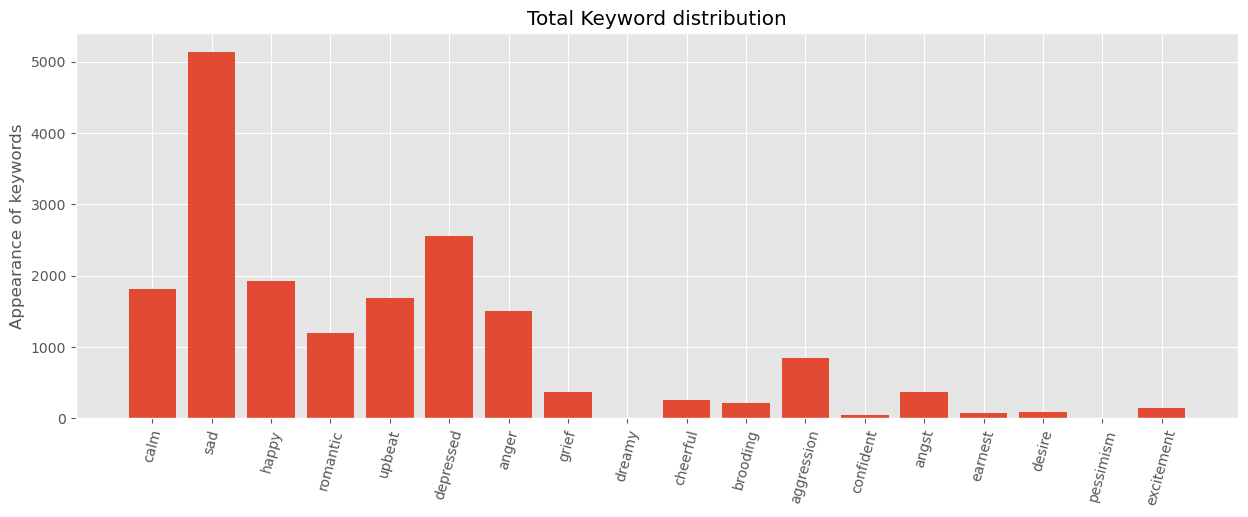

In [53]:
labels = keyword_distibution.keys()
data = keyword_distibution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)

ax.set_ylabel('Appearance of keywords')
plt.title('Total Keyword distribution')
plt.show()

# The figure shows how often the keywords of a mood category appear in all english texts

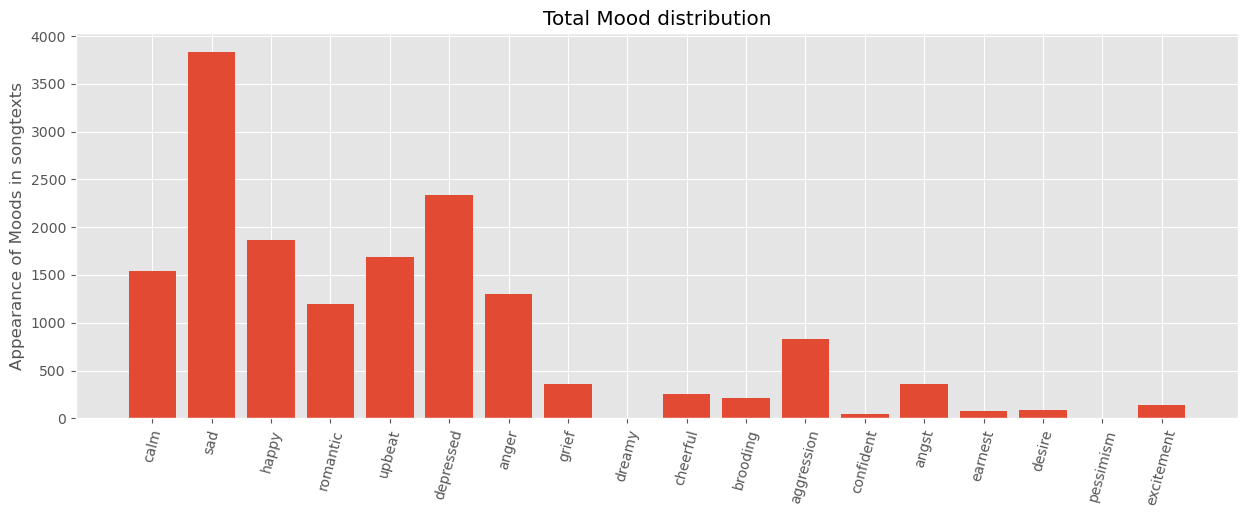

In [54]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

### Now plot the distribution with regards to the total ammount of songs

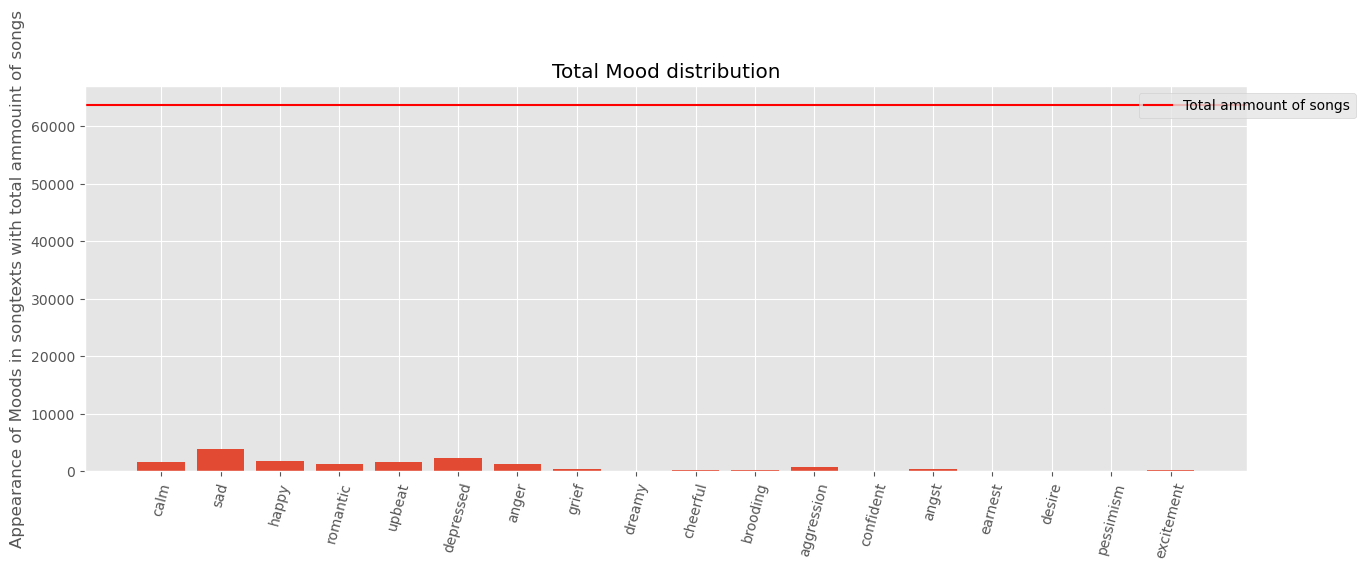

In [55]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts with total ammouint of songs')
plt.title('Total Mood distribution')
plt.axhline(y = len(artists_songs_dataframe["Tags"]), color = 'r', linestyle = '-', label = "Total ammount of songs")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.show()

### Now we will calculate how many songs can be identified with a mood at all

In [69]:
songs_without_moods = 0

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = tag_string.split(", ")
    flag = 0
    for mood in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[mood]:
            if keyword in tag_list:
                flag = 1
                break
    if flag == 0:
        songs_without_moods += 1


Number of songs with mood: 10211, which is 16.01% of all songs.


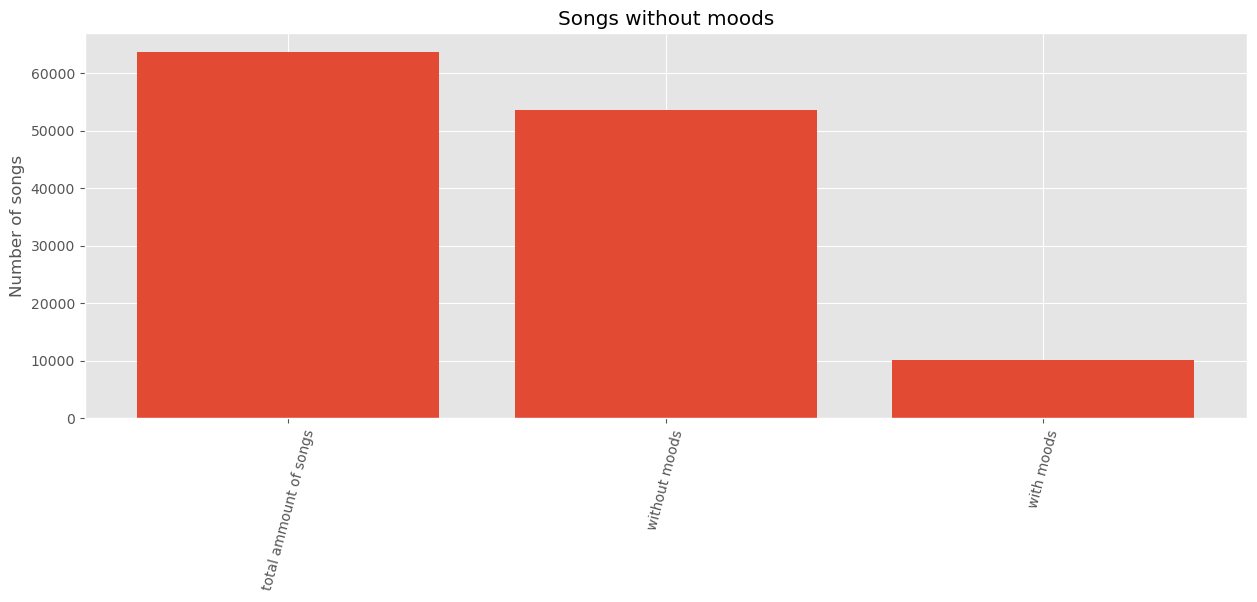

In [57]:
# the following figure shows the ammount of songs not containing any of the mood keywords

labels = ["total ammount of songs", "without moods", "with moods"]
songs_with_moood = len(artists_songs_dataframe["Tags"])-songs_without_moods
print(f"Number of songs with mood: {songs_with_moood}, which is {np.round(100*songs_with_moood/len(artists_songs_dataframe['Tags']), 2)}% of all songs.")
data = [ len(artists_songs_dataframe["Tags"]), songs_without_moods, songs_with_moood ]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Number of songs')
plt.title('Songs without moods')
plt.show()

# Mood keyword distribution (with advanced keyword set)

Concept based on: https://github.com/workmanjack/lyric-mood-classification

### Expanding the Categories

The last.fm dataset is generated by users without scientific rigor in mind. There is a chance that searching for an exact match on a mood and its related moods will not always yield all possible matches. In this section, we will explore additional tags that match with each category.

In [58]:
# TODO: Maybe add filters afterwards (e.g., for words like happy -> unhappy)

def find_tags_containing_keyword(df):
    """Return an advanced mood keyword dictionary based on our dataset and the base mood keywords (defined above).

    :param df: dataframe consisting of columns 'Artist', 'SName' and 'Tags' specifying the artist, song name and tags defined by users.
    
    :return: dictionary containing more mood keywords (values) for each mood (key) based on our dataset and the base mood keywords.
    :rtype: Dictionary
    """
    
    # Get all unique tags
    unique_tag_list = list(set([tag.lower() for tags in df["Tags"] for tag in tags.split(", ")]))
    
    # Check for each keyword of specific mood if this keyword is contained in the tags (do lower casing)
    advanced_mood_keyword_dict = {}
    for mood, keywords in MOOD_CATEGORIES.items():
        advanced_mood_keyword_dict[mood] = []
        for mood_keyword in keywords:
            for tag in unique_tag_list:
                if mood_keyword in tag:
                    advanced_mood_keyword_dict[mood].append(tag)
    
    return advanced_mood_keyword_dict

In [59]:
# TODO: Analyze mood keywords and look for missmatch (e.g., for words like happy -> unhappy)
# TODO: Create manual filters

advanced_mood_keyword_dict = find_tags_containing_keyword(artists_songs_dataframe)

print("Base mood keywords:")
print(MOOD_CATEGORIES)

print("Advanced mood keywords:")
print(advanced_mood_keyword_dict)

Base mood keywords:
{'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'], 'sad': ['sadness', 'unhappy', 'melancholic', 'melancholy'], 'happy': ['happy', 'happiness', 'happy songs', 'happy music'], 'romantic': ['romantic', 'romantic music'], 'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusiastic'], 'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'], 'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'], 'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'], 'dreamy': ['dreamy'], 'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'], 'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'], 'aggression': ['aggression', 'aggressive'], 'confident': ['confident', 'encouraging', 'encouragement', 'optimism'], 'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'], 'earnest': ['earnest', 'heartfelt'], 'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'], 'pessimism': 

### Advanced mood keywords distribution

In [60]:
# Compute number of songs that can be assigned to a mood based on occuring keywords
num_moods = len(advanced_mood_keyword_dict)
keyword_distibution = dict(zip(advanced_mood_keyword_dict.keys(), [0]*num_moods))
for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = tag_string.split(", ")
    for mood in advanced_mood_keyword_dict:
        for keyword in advanced_mood_keyword_dict[mood]:
            if keyword in tag_list:                
                keyword_distibution[mood] += 1

In [61]:
# This approach only considers the first appearing mood keyword for the overall mood of the song
# --> Will assign the moods more sophisticatedly later in the project
song_distribution= dict(zip(advanced_mood_keyword_dict.keys(), [0]*num_moods))

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = tag_string.split(", ")
    for mood in advanced_mood_keyword_dict:
        for keyword in advanced_mood_keyword_dict[mood]:
            if keyword in tag_list:
                song_distribution[mood] += 1
                break


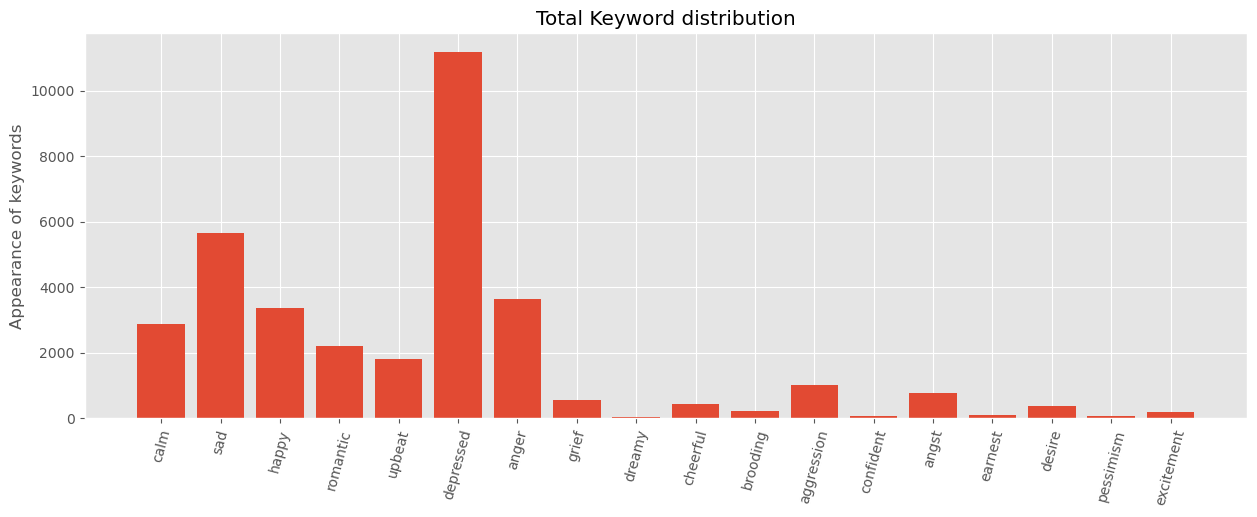

In [62]:
labels = keyword_distibution.keys()
data = keyword_distibution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)

ax.set_ylabel('Appearance of keywords')
plt.title('Total Keyword distribution')
plt.show()

# The figure shows how often the keywords of a mood category appear in all english texts

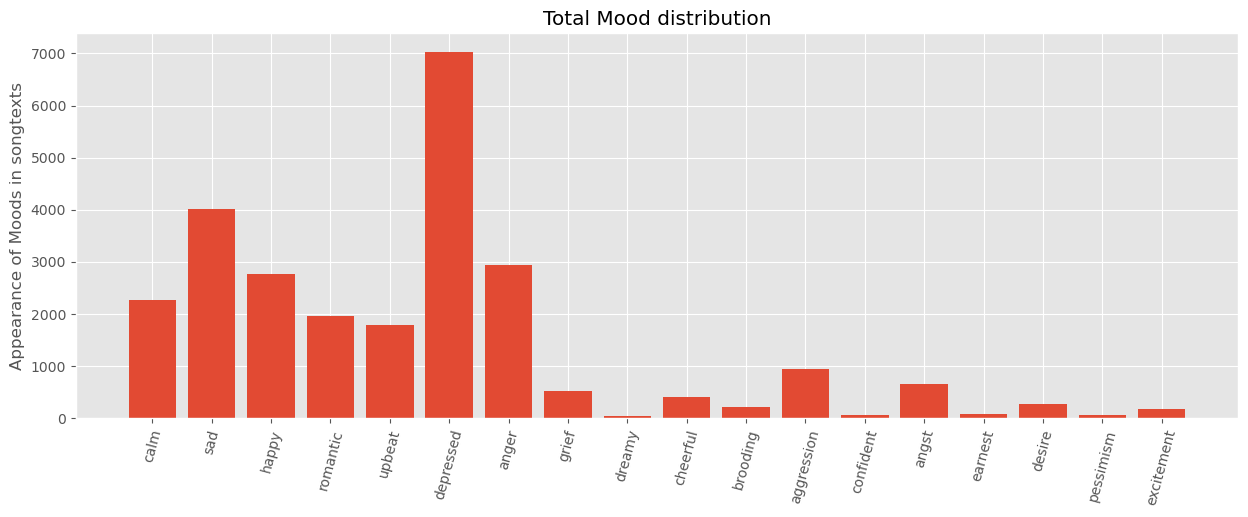

In [63]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

#### Now plot the distribution with regards to the total ammount of songs

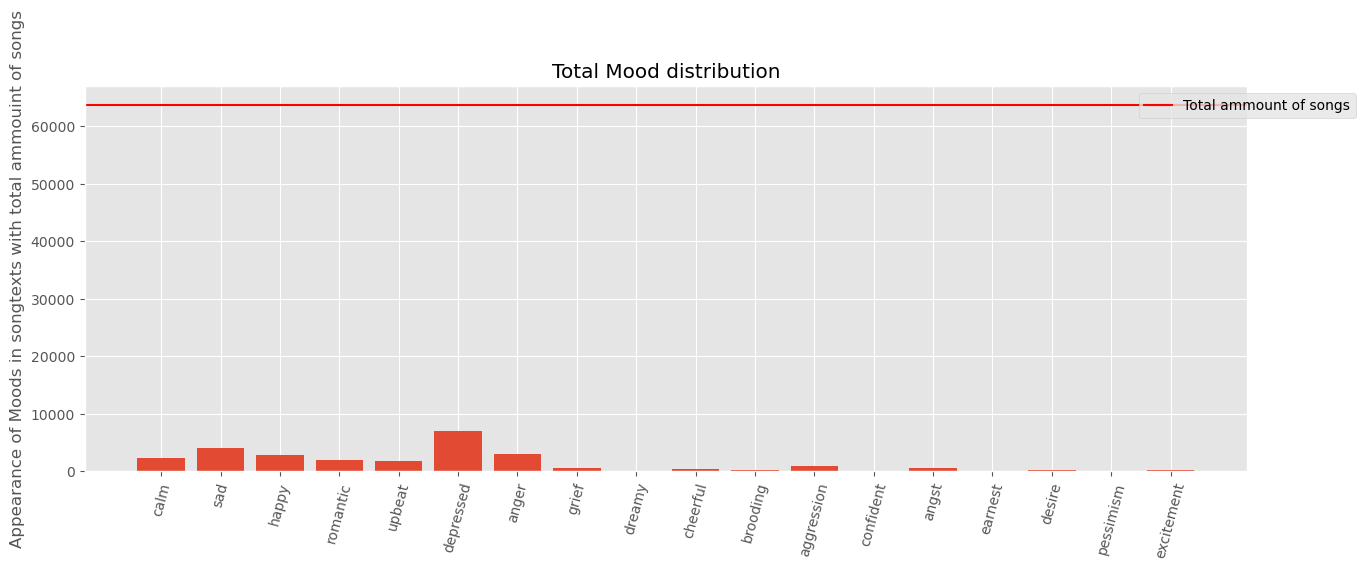

In [64]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = song_distribution.keys()
data = song_distribution.values()
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts with total ammouint of songs')
plt.title('Total Mood distribution')
plt.axhline(y = len(artists_songs_dataframe["Tags"]), color = 'r', linestyle = '-', label = "Total ammount of songs")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.show()

#### Now we will calculate how many songs can be identified with a mood at all

In [70]:
songs_without_moods = 0

for tag_string in artists_songs_dataframe["Tags"]:
    tag_list = tag_string.split(", ")
    flag = 0
    for mood in advanced_mood_keyword_dict:
        for keyword in advanced_mood_keyword_dict[mood]:
            if keyword in tag_list:
                flag = 1
                break
    if flag == 0:
        songs_without_moods += 1


Number of songs with mood: 15822, which is 24.8% of all songs.


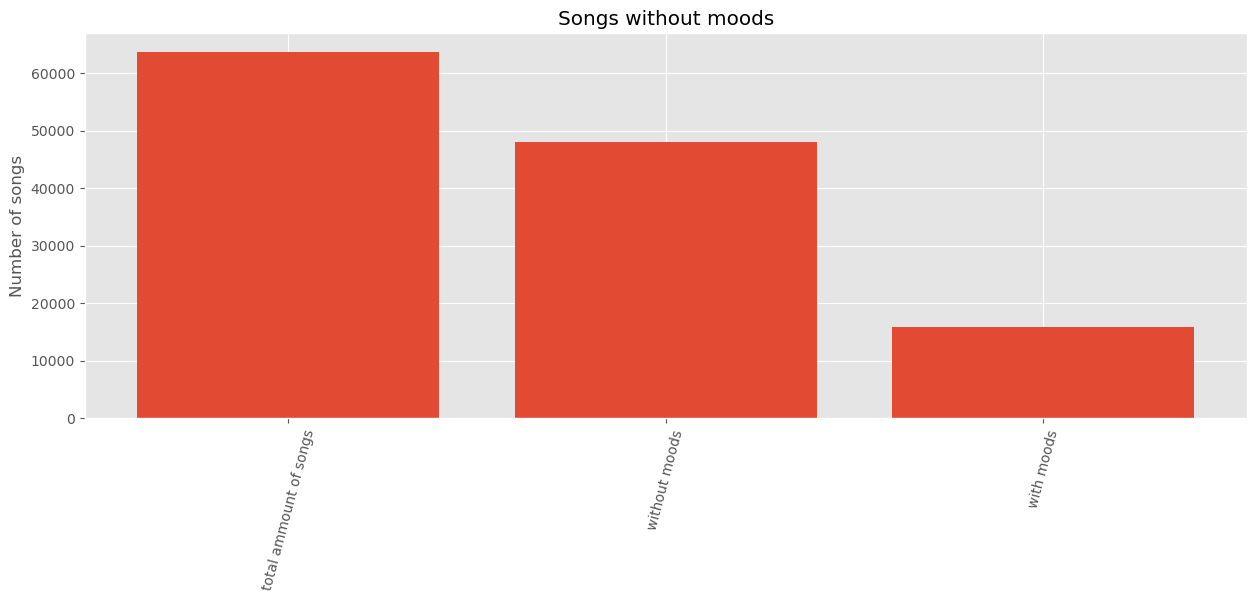

In [66]:
# the following figure shows the ammount of songs not containing any of the mood keywords

labels = ["total ammount of songs", "without moods", "with moods"]
songs_with_moood = len(artists_songs_dataframe["Tags"])-songs_without_moods
print(f"Number of songs with mood: {songs_with_moood}, which is {np.round(100*songs_with_moood/len(artists_songs_dataframe['Tags']), 2)}% of all songs.")
data = [ len(artists_songs_dataframe["Tags"]), songs_without_moods, songs_with_moood ]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Number of songs')
plt.title('Songs without moods')
plt.show()